In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

In [3]:
from sklearn.preprocessing import LabelEncoder
train = pd.read_csv("mertrain.csv")
test = pd.read_csv("mertest.csv")

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [4]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X = train.drop(['y','ID'], axis=1).values
X_test= test.drop(['ID'], axis=1).values

In [5]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X)

5

In [6]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [9]:
# xgboost for noomal param=max_depth4
import xgboost as xgb

# prepare dict of params for xgboost to run with
#xgb_params = {
#    'n_trees': 500, 
#    'eta': 0.005,
#    'max_depth': 4,
#    'subsample': 0.95,
#    'objective': 'reg:linear',
#    'eval_metric': 'rmse',
#    'base_score': y_mean, # base prediction = mean(target)
#    'silent': 1
#}
xgb_params={
    'gamma': 1.0,
    'eta': 0.01,
    'max_depth': 3,
    'subsample':1.0,
    'objective' : 'reg:linear',
    'eval_metric': 'rmse',
    'base_score' : y_mean,
    'silent': 1,
    'lambda': 1,
    'alpha' : 0
}

#form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train, y_train)
dvalid=xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6979	test-rmse:12.691
[50]	train-rmse:10.1947	test-rmse:10.2313
[100]	train-rmse:9.08338	test-rmse:9.16094
[150]	train-rmse:8.61895	test-rmse:8.73455
[200]	train-rmse:8.41065	test-rmse:8.55961
[250]	train-rmse:8.3009	test-rmse:8.48994
[300]	train-rmse:8.22593	test-rmse:8.46354
[350]	train-rmse:8.1625	test-rmse:8.45288
[400]	train-rmse:8.11398	test-rmse:8.44847
[450]	train-rmse:8.0722	test-rmse:8.44948
417


In [10]:
from sklearn.metrics import r2_score
print("R^2 valid: {: }".format(r2_score(y_valid, model.predict(dvalid))))
print("R^2 train: {: }".format(r2_score(y_train, model.predict(dtrain))))

R^2 valid:  0.5927315842647876
R^2 train:  0.5879560173351377


In [11]:
y_pred_xgb = model.predict(dtest)

In [12]:
# the most 5 important feature extracted by xgboost 
train_important=train[["X315","X314","X118","X29","X0","X127","X5","X47","X3","X1"]]
test_important=test[["X315","X314","X118","X29","X0","X127","X5","X47","X3","X1"]]

In [13]:
# pca decomposition into new datasers 
n_comp = 30
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

In [14]:
# make it dataframe
df_pca_train=pd.DataFrame(pca2_results_train)
df_pca_test=pd.DataFrame(pca2_results_test)

In [15]:
# make new datasets including pca decomposition and important feature 
train_pca_important= pd.concat([df_pca_train, train_important], axis=1, join='inner')
test_pca_important=pd.concat([df_pca_test, test_important], axis=1, join='inner')

In [16]:
for train_index, test_index in kf.split(train_pca_important):
    X_train2, y_train2=train_pca_important.values[train_index], y[train_index]
    X_valid2, y_valid2=train_pca_important.values[test_index], y[test_index]

In [18]:
#xgb_params2 = {
#    'n_trees': 500, 
#    'eta': 0.005,
#    'max_depth': 4,
#    'subsample': 0.95,
#    'objective': 'reg:linear',
#    'eval_metric': 'rmse',
#    'base_score': y_mean, # base prediction = mean(target)
#    'silent': 1
#}
xgb_parames={
    'gamma': 1.0,
    'eta': 0.01,
    'max_depth': 3,
    'subsample':1.0,
    'objective' : 'reg:linear',
    'eval_metric': 'rmse',
    'base_score' : y_mean,
    'silent': 1,
    'lambda': 1,
    'alpha' : 0
}

# form DMatrices for Xgboost training
dtrain2 = xgb.DMatrix(X_train2, y_train2)
dvalid2=xgb.DMatrix(X_valid2, y_valid2)
dtest2 = xgb.DMatrix(test_pca_important.values)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params2, 
                   dtrain2, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model2 = xgb.train(dict(xgb_params2, silent=0), dtrain2, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.7325	test-rmse:12.7273
[50]	train-rmse:11.1731	test-rmse:11.2669
[100]	train-rmse:10.0896	test-rmse:10.2789
[150]	train-rmse:9.34901	test-rmse:9.62855
[200]	train-rmse:8.84639	test-rmse:9.21213
[250]	train-rmse:8.50688	test-rmse:8.95345
[300]	train-rmse:8.26947	test-rmse:8.79692
[350]	train-rmse:8.08218	test-rmse:8.70885
[400]	train-rmse:7.91481	test-rmse:8.65805
[450]	train-rmse:7.76648	test-rmse:8.63065
[499]	train-rmse:7.63559	test-rmse:8.61394
500


In [19]:
print("R^2 valid: {: }".format(r2_score(y_valid, model2.predict(dvalid2))))
print("R^2 train: {: }".format(r2_score(y_train, model2.predict(dtrain2))))

R^2 valid:  0.5856221010636866
R^2 train:  0.6146487627918052


In [20]:
y_pred_xgb2 = model2.predict(dtest2)

In [21]:
y_pre_pred=model.predict(dvalid)*0.7+model2.predict(dvalid2)*0.3
y_train_pred=model.predict(dtrain)*0.7+model2.predict(dtrain2)*0.3

In [22]:
print("R^2 train: {: }".format(r2_score(y_train, y_train_pred )))
print("R^2 valid: {: }".format(r2_score(y_valid, y_pre_pred)))

R^2 train:  0.5979631199946376
R^2 valid:  0.5920920182030937


In [23]:
pist_valid=[]
pist_train=[]
for i in range(1,10):
    y_pre_pred=model.predict(dvalid)*i*0.1+ model2.predict(dvalid2)*(1.0-i*0.1)
    y_train_pred=model.predict(dtrain)*i*0.1+model2.predict(dtrain2)*(1.0-i*0.1)
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    pist_valid.append(r2_valid)
    pist_train.append(r2_train)

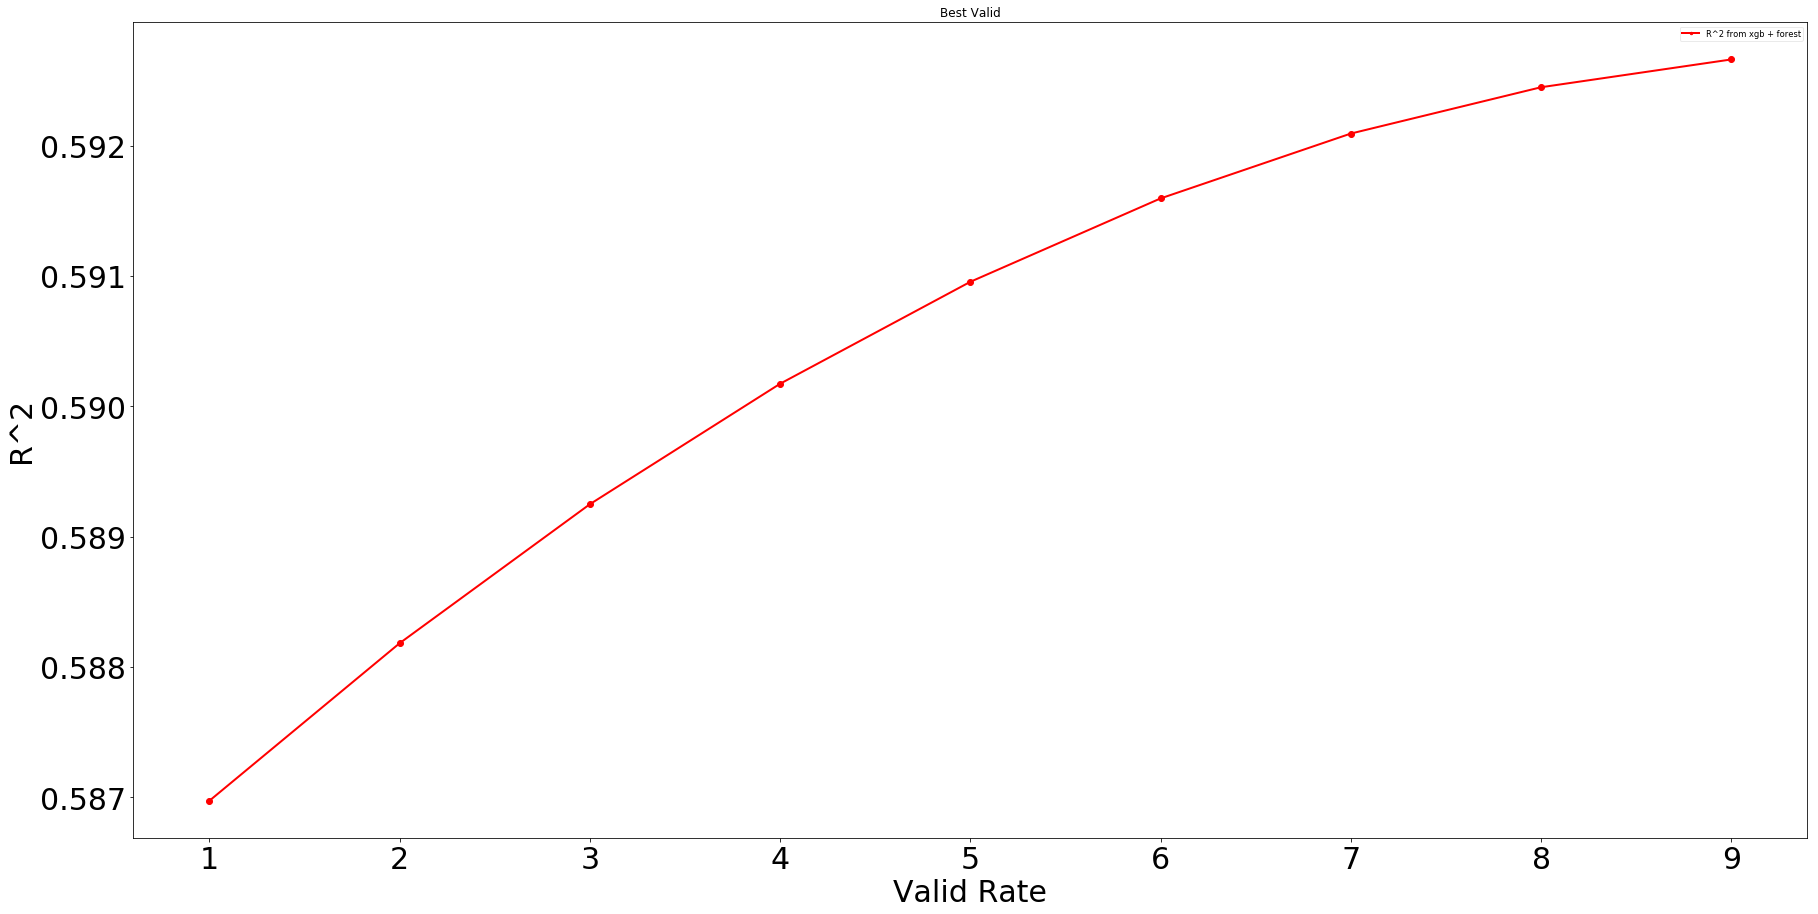

In [24]:
# for valid ration of nomal-xgboost : stacked-xgboost

ig = plt.figure(figsize=(30,15))
plt.plot(range(1, 10), pist_valid, 'ro-', linewidth=2)
plt.title('Best Valid')
plt.xlabel('Valid Rate', fontsize=30)
plt.ylabel('R^2', fontsize=30)
plt.tick_params(labelsize=30)
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

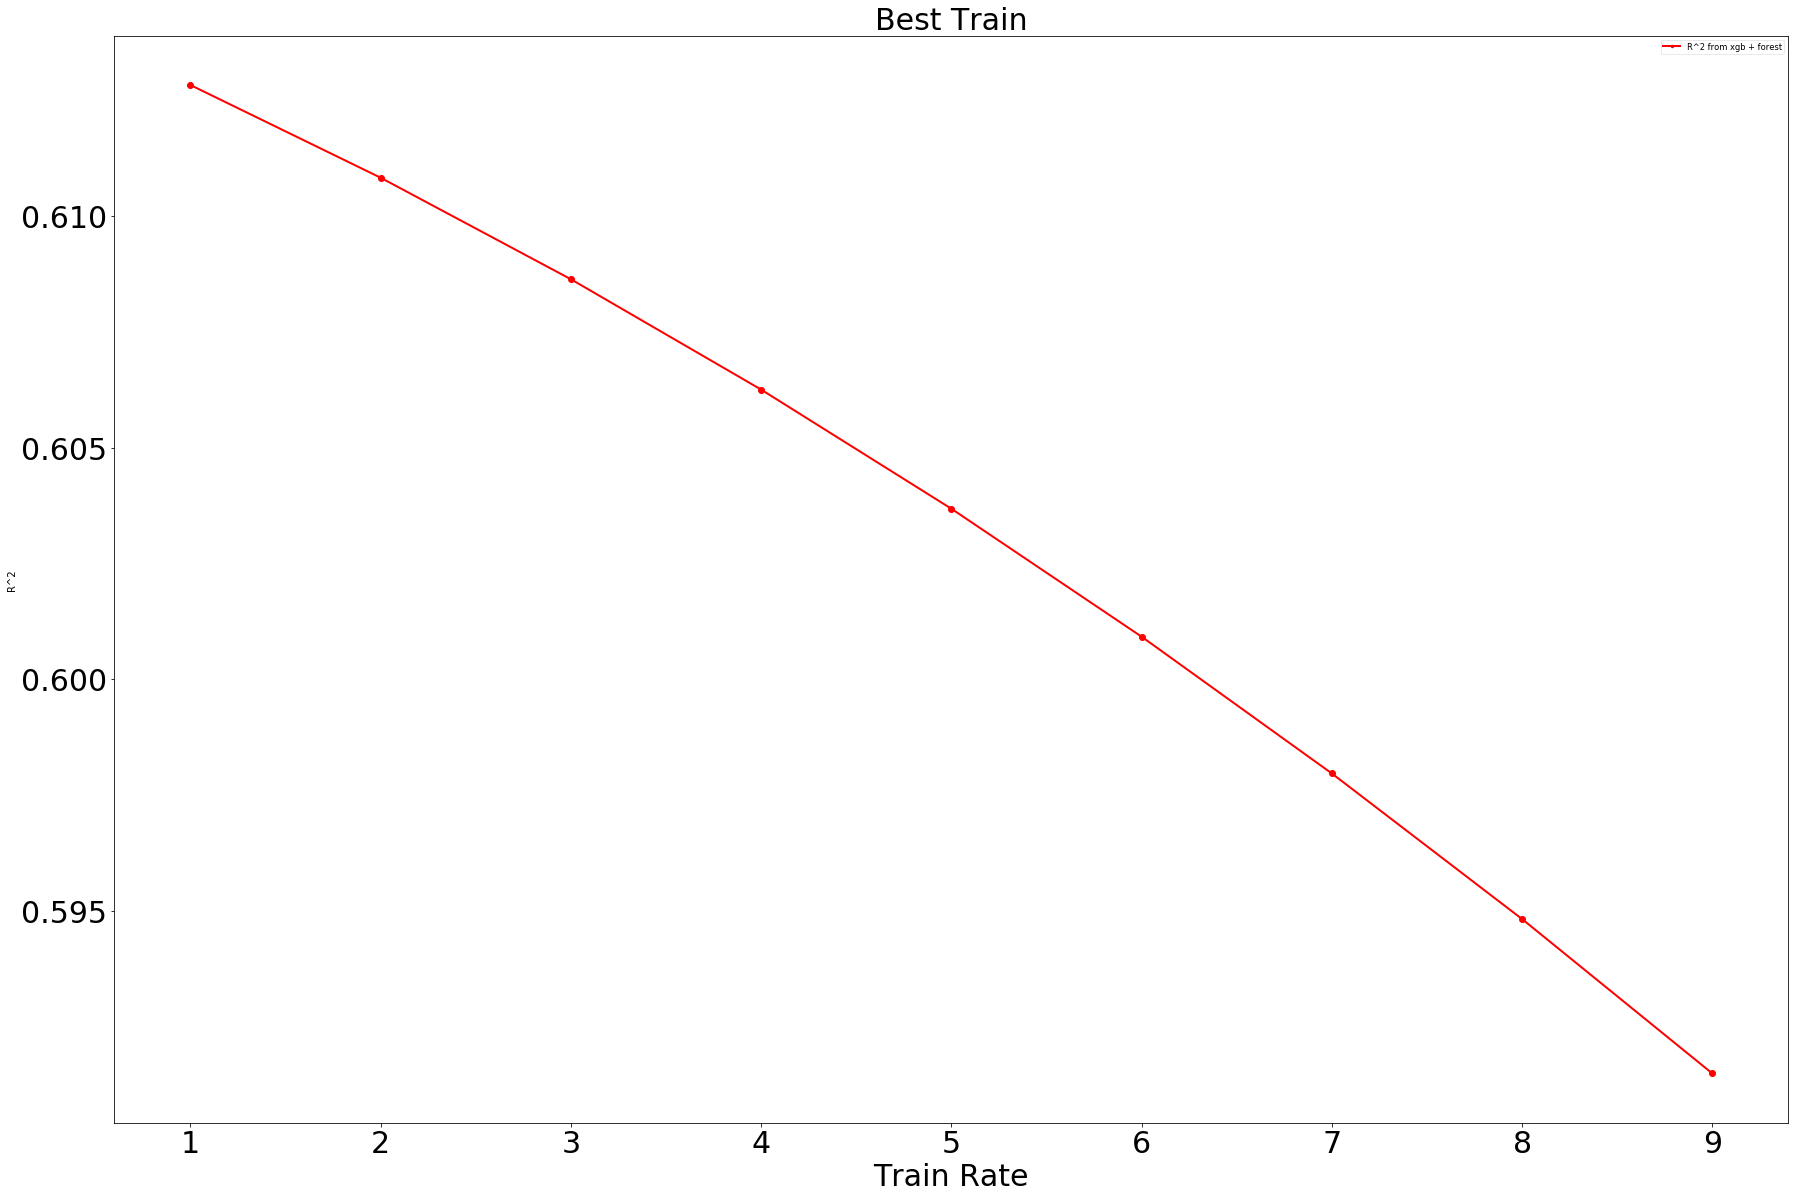

In [25]:
# for train ratio of nomal-xgboost ; stacked-xgboost
ig = plt.figure(figsize=(30,20))
plt.plot(range(1, 10), pist_train, 'ro-', linewidth=2)
plt.title('Best Train',fontsize=30)
plt.xlabel('Train Rate', fontsize=30)
plt.ylabel('R^2')
plt.tick_params(labelsize=30)
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

In [26]:
y_pred=y_pred_xgb*0.7+ y_pred_xgb2*0.3

In [57]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred
sub.to_csv('average-xgb-nomal7+xgb-pca30-impo10-3.csv', index=False)